#  K-Means y Variantes
## Algoritmos de Particionamiento para Clustering

### Objetivos del Notebook

1. Implementar el algoritmo K-Means paso a paso para comprender su funcionamiento interno
2. Utilizar las implementaciones de scikit-learn: `KMeans` y `MiniBatchKMeans`
3. Aplicar métodos para determinar el número óptimo de clusters
4. Visualizar centroides, asignaciones y fronteras de decisión
5. Realizar un ejercicio práctico de segmentación de clientes

---

## 1. Configuración del Entorno

Importamos las bibliotecas necesarias para el desarrollo del módulo.

In [ ]:
# Bibliotecas fundamentales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Scikit-learn: clustering y métricas
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


## 2. Generación de Datos Sintéticos

Para ilustrar el funcionamiento de K-Means, generamos un conjunto de datos sintético con estructura de clusters bien definida.

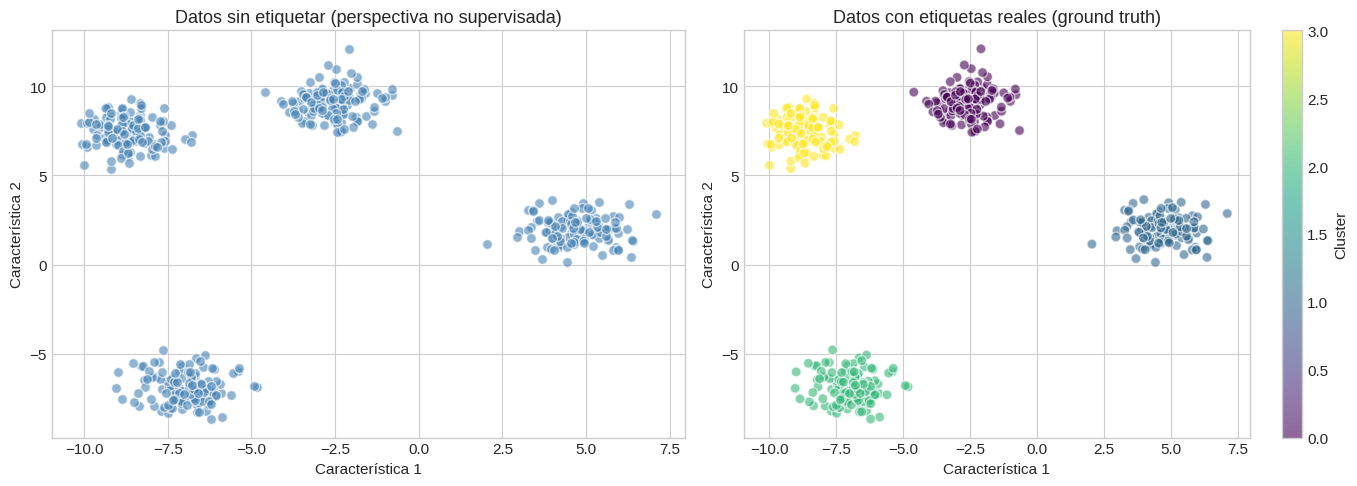

Dimensiones del dataset: (500, 2)
Número de clusters reales: 4


In [ ]:
# Generación de datos con 4 clusters
n_samples = 500
n_clusters_true = 4

X, y_true = make_blobs(
    n_samples=n_samples,
    n_features=2,
    centers=n_clusters_true,
    cluster_std=0.8,
    random_state=RANDOM_STATE
)

# Visualización de los datos originales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sin etiquetas (perspectiva no supervisada)
axes[0].scatter(X[:, 0], X[:, 1], c='steelblue', alpha=0.6, edgecolors='w', s=50)
axes[0].set_xlabel('Característica 1')
axes[0].set_ylabel('Característica 2')
axes[0].set_title('Datos sin etiquetar (perspectiva no supervisada)')

# Con etiquetas reales (ground truth)
scatter = axes[1].scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.6, edgecolors='w', s=50)
axes[1].set_xlabel('Característica 1')
axes[1].set_ylabel('Característica 2')
axes[1].set_title('Datos con etiquetas reales (ground truth)')
plt.colorbar(scatter, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

print(f"Dimensiones del dataset: {X.shape}")
print(f"Número de clusters reales: {n_clusters_true}")

## 3. Implementación de K-Means desde Cero

Antes de utilizar las implementaciones optimizadas de scikit-learn, es fundamental comprender el funcionamiento interno del algoritmo. A continuación, implementamos K-Means paso a paso.

### 3.1 Función Objetivo: Within-Cluster Sum of Squares (WCSS)

La función objetivo que K-Means minimiza es la inercia o WCSS:

$$J = \sum_{k=1}^{K} \sum_{x_i \in C_k} ||x_i - \mu_k||^2$$

donde $C_k$ es el conjunto de puntos asignados al cluster $k$ y $\mu_k$ es el centroide del cluster $k$.

In [ ]:
def calcular_wcss(X, centroides, asignaciones):
    """
    Calcula la inercia (Within-Cluster Sum of Squares).

    Parámetros
    ----------
    X : ndarray de forma (n_samples, n_features)
        Matriz de datos.
    centroides : ndarray de forma (k, n_features)
        Posición de los centroides.
    asignaciones : ndarray de forma (n_samples,)
        Índice del cluster asignado a cada punto.

    Retorna
    -------
    float
        Valor de la inercia.
    """
    wcss = 0.0
    for k in range(len(centroides)):
        puntos_cluster = X[asignaciones == k]
        if len(puntos_cluster) > 0:
            wcss += np.sum((puntos_cluster - centroides[k]) ** 2)
    return wcss

### 3.2 Implementación del Algoritmo K-Means

In [ ]:
class KMeansManual:
    """
    Implementación didáctica del algoritmo K-Means.

    Esta implementación prioriza la claridad sobre la eficiencia
    para facilitar la comprensión del algoritmo.

    Parámetros
    ----------
    n_clusters : int
        Número de clusters a formar.
    max_iter : int, default=100
        Número máximo de iteraciones.
    tol : float, default=1e-4
        Tolerancia para declarar convergencia.
    random_state : int, default=None
        Semilla para reproducibilidad.

    Atributos
    ---------
    centroides_ : ndarray de forma (n_clusters, n_features)
        Coordenadas de los centroides finales.
    labels_ : ndarray de forma (n_samples,)
        Etiquetas de cluster para cada punto.
    inertia_ : float
        Suma de distancias al cuadrado al centroide más cercano.
    n_iter_ : int
        Número de iteraciones ejecutadas.
    historial_wcss_ : list
        Evolución de la inercia por iteración.
    """

    def __init__(self, n_clusters, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def _inicializar_centroides(self, X):
        """
        Inicialización aleatoria: selecciona k puntos del dataset.
        """
        rng = np.random.RandomState(self.random_state)
        indices = rng.choice(len(X), size=self.n_clusters, replace=False)
        return X[indices].copy()

    def _asignar_clusters(self, X, centroides):
        """
        Paso de asignación: cada punto al centroide más cercano.
        """
        # Calcular distancias de cada punto a cada centroide
        distancias = np.zeros((len(X), self.n_clusters))
        for k in range(self.n_clusters):
            distancias[:, k] = np.sqrt(np.sum((X - centroides[k]) ** 2, axis=1))

        # Asignar al centroide más cercano
        return np.argmin(distancias, axis=1)

    def _actualizar_centroides(self, X, asignaciones):
        """
        Paso de actualización: recalcular centroides como media de puntos asignados.
        """
        nuevos_centroides = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            puntos_cluster = X[asignaciones == k]
            if len(puntos_cluster) > 0:
                nuevos_centroides[k] = puntos_cluster.mean(axis=0)
            else:
                # Cluster vacío: mantener centroide anterior o reinicializar
                nuevos_centroides[k] = self.centroides_[k]
        return nuevos_centroides

    def fit(self, X):
        """
        Ajusta el modelo K-Means a los datos.

        Parámetros
        ----------
        X : ndarray de forma (n_samples, n_features)
            Datos de entrenamiento.

        Retorna
        -------
        self
            El objeto ajustado.
        """
        # Paso 1: Inicialización
        self.centroides_ = self._inicializar_centroides(X)
        self.historial_wcss_ = []

        for iteracion in range(self.max_iter):
            # Paso 2: Asignación
            self.labels_ = self._asignar_clusters(X, self.centroides_)

            # Calcular WCSS actual
            wcss_actual = calcular_wcss(X, self.centroides_, self.labels_)
            self.historial_wcss_.append(wcss_actual)

            # Paso 3: Actualización
            nuevos_centroides = self._actualizar_centroides(X, self.labels_)

            # Verificar convergencia
            desplazamiento = np.sqrt(np.sum((nuevos_centroides - self.centroides_) ** 2))
            self.centroides_ = nuevos_centroides

            if desplazamiento < self.tol:
                break

        self.n_iter_ = iteracion + 1
        self.inertia_ = self.historial_wcss_[-1]

        return self

    def predict(self, X):
        """
        Predice el cluster más cercano para cada muestra.
        """
        return self._asignar_clusters(X, self.centroides_)

### 3.3 Ejecución y Visualización del Proceso Iterativo

In [ ]:
# Ajustar modelo K-Means manual
kmeans_manual = KMeansManual(n_clusters=4, max_iter=100, random_state=RANDOM_STATE)
kmeans_manual.fit(X)

print(f"Número de iteraciones hasta convergencia: {kmeans_manual.n_iter_}")
print(f"Inercia final (WCSS): {kmeans_manual.inertia_:.2f}")
print(f"\nCentroides encontrados:")
for i, centroide in enumerate(kmeans_manual.centroides_):
    print(f"  Cluster {i}: ({centroide[0]:.3f}, {centroide[1]:.3f})")

Número de iteraciones hasta convergencia: 5
Inercia final (WCSS): 607.29

Centroides encontrados:
  Cluster 0: (4.705, 1.934)
  Cluster 1: (-6.977, -6.900)
  Cluster 2: (-8.713, 7.429)
  Cluster 3: (-2.584, 9.077)


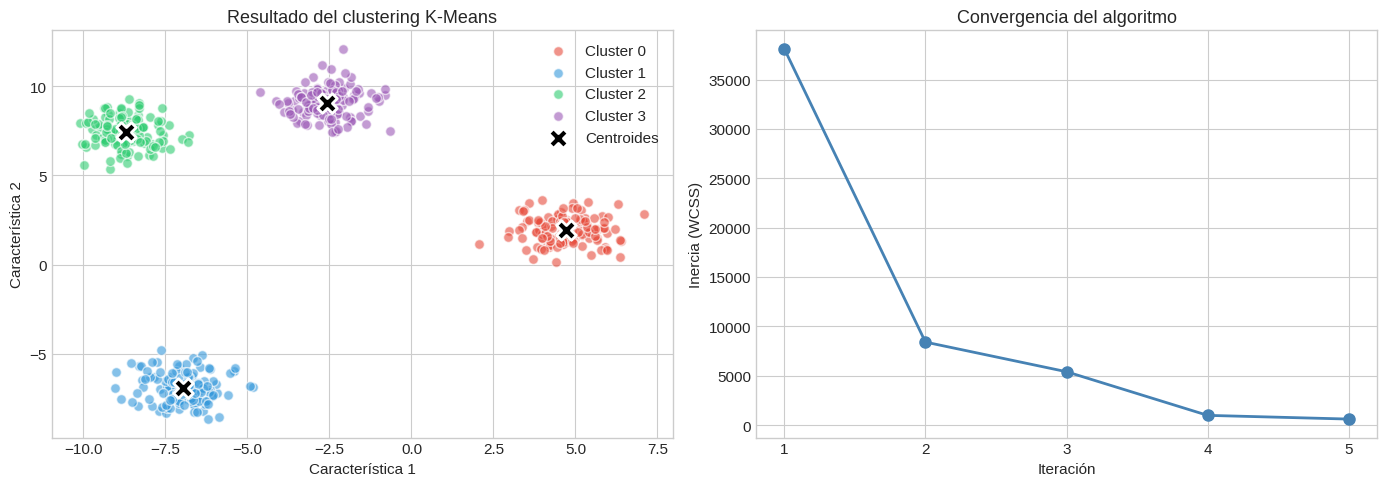

In [ ]:
# Visualización de resultados
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Clusters encontrados
colores = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
for k in range(4):
    mask = kmeans_manual.labels_ == k
    axes[0].scatter(X[mask, 0], X[mask, 1], c=colores[k], label=f'Cluster {k}',
                    alpha=0.6, edgecolors='w', s=50)

# Centroides
axes[0].scatter(kmeans_manual.centroides_[:, 0], kmeans_manual.centroides_[:, 1],
                c='black', marker='X', s=200, edgecolors='white', linewidths=2,
                label='Centroides')
axes[0].set_xlabel('Característica 1')
axes[0].set_ylabel('Característica 2')
axes[0].set_title('Resultado del clustering K-Means')
axes[0].legend()

# Evolución de la inercia
axes[1].plot(range(1, len(kmeans_manual.historial_wcss_) + 1),
             kmeans_manual.historial_wcss_, 'o-', color='steelblue', linewidth=2, markersize=8)
axes[1].set_xlabel('Iteración')
axes[1].set_ylabel('Inercia (WCSS)')
axes[1].set_title('Convergencia del algoritmo')
axes[1].set_xticks(range(1, len(kmeans_manual.historial_wcss_) + 1))

plt.tight_layout()
plt.show()

## 4. K-Means con Scikit-learn

La implementación de scikit-learn incluye optimizaciones importantes y características adicionales como K-Means++ para la inicialización.

In [ ]:
# K-Means con scikit-learn
kmeans_sklearn = KMeans(
    n_clusters=4,
    init='k-means++',      # Inicialización inteligente
    n_init=10,             # Número de ejecuciones con diferentes inicializaciones
    max_iter=300,
    random_state=RANDOM_STATE
)

kmeans_sklearn.fit(X)

print("Comparación de implementaciones:")
print(f"{'Métrica':<25} {'Manual':<15} {'Scikit-learn':<15}")
print("-" * 55)
print(f"{'Inercia (WCSS)':<25} {kmeans_manual.inertia_:<15.2f} {kmeans_sklearn.inertia_:<15.2f}")
print(f"{'Iteraciones':<25} {kmeans_manual.n_iter_:<15} {kmeans_sklearn.n_iter_:<15}")

Comparación de implementaciones:
Métrica                   Manual          Scikit-learn   
-------------------------------------------------------
Inercia (WCSS)            607.29          607.29         
Iteraciones               5               2              


### 4.1 Efecto de la Inicialización: Aleatoria vs K-Means++

Comparamos el impacto de diferentes estrategias de inicialización en la calidad del resultado.

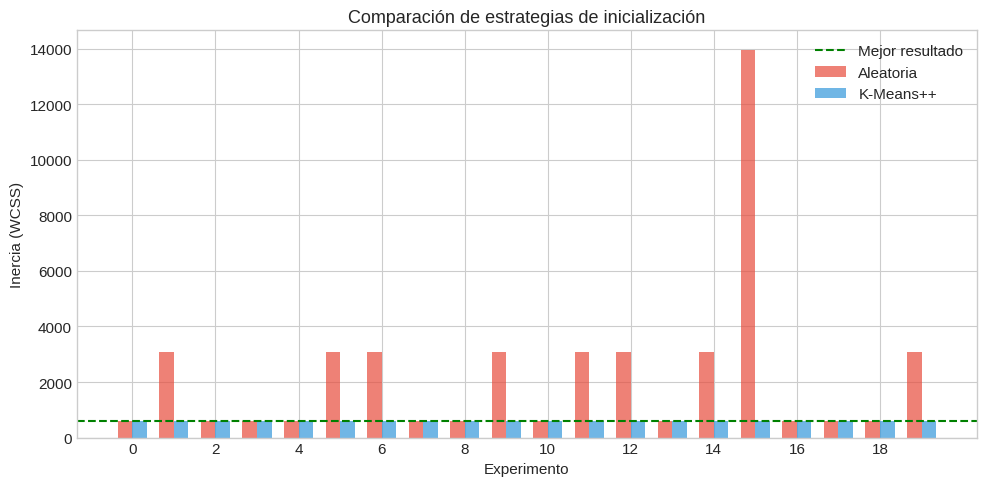


Estadísticas de inercia:
Inicialización  Media        Std          Mín          Máx         
---------------------------------------------------------------
Aleatoria       2258.97      2933.45      607.29       13957.77    
K-Means++       607.29       0.00         607.29       607.29      


In [ ]:
# Comparación de inicializaciones
n_experimentos = 20
inercias_random = []
inercias_kmeanspp = []

for i in range(n_experimentos):
    # Inicialización aleatoria
    km_random = KMeans(n_clusters=4, init='random', n_init=1, random_state=i)
    km_random.fit(X)
    inercias_random.append(km_random.inertia_)

    # Inicialización K-Means++
    km_pp = KMeans(n_clusters=4, init='k-means++', n_init=1, random_state=i)
    km_pp.fit(X)
    inercias_kmeanspp.append(km_pp.inertia_)

# Visualización
fig, ax = plt.subplots(figsize=(10, 5))

posiciones = np.arange(n_experimentos)
ancho = 0.35

bars1 = ax.bar(posiciones - ancho/2, inercias_random, ancho, label='Aleatoria', color='#e74c3c', alpha=0.7)
bars2 = ax.bar(posiciones + ancho/2, inercias_kmeanspp, ancho, label='K-Means++', color='#3498db', alpha=0.7)

ax.axhline(y=np.min(inercias_kmeanspp), color='green', linestyle='--', linewidth=1.5, label='Mejor resultado')
ax.set_xlabel('Experimento')
ax.set_ylabel('Inercia (WCSS)')
ax.set_title('Comparación de estrategias de inicialización')
ax.legend()
ax.set_xticks(posiciones[::2])

plt.tight_layout()
plt.show()

print(f"\nEstadísticas de inercia:")
print(f"{'Inicialización':<15} {'Media':<12} {'Std':<12} {'Mín':<12} {'Máx':<12}")
print("-" * 63)
print(f"{'Aleatoria':<15} {np.mean(inercias_random):<12.2f} {np.std(inercias_random):<12.2f} {np.min(inercias_random):<12.2f} {np.max(inercias_random):<12.2f}")
print(f"{'K-Means++':<15} {np.mean(inercias_kmeanspp):<12.2f} {np.std(inercias_kmeanspp):<12.2f} {np.min(inercias_kmeanspp):<12.2f} {np.max(inercias_kmeanspp):<12.2f}")

### 4.2 Visualización de Fronteras de Decisión

Las regiones de Voronoi muestran cómo K-Means particiona el espacio.

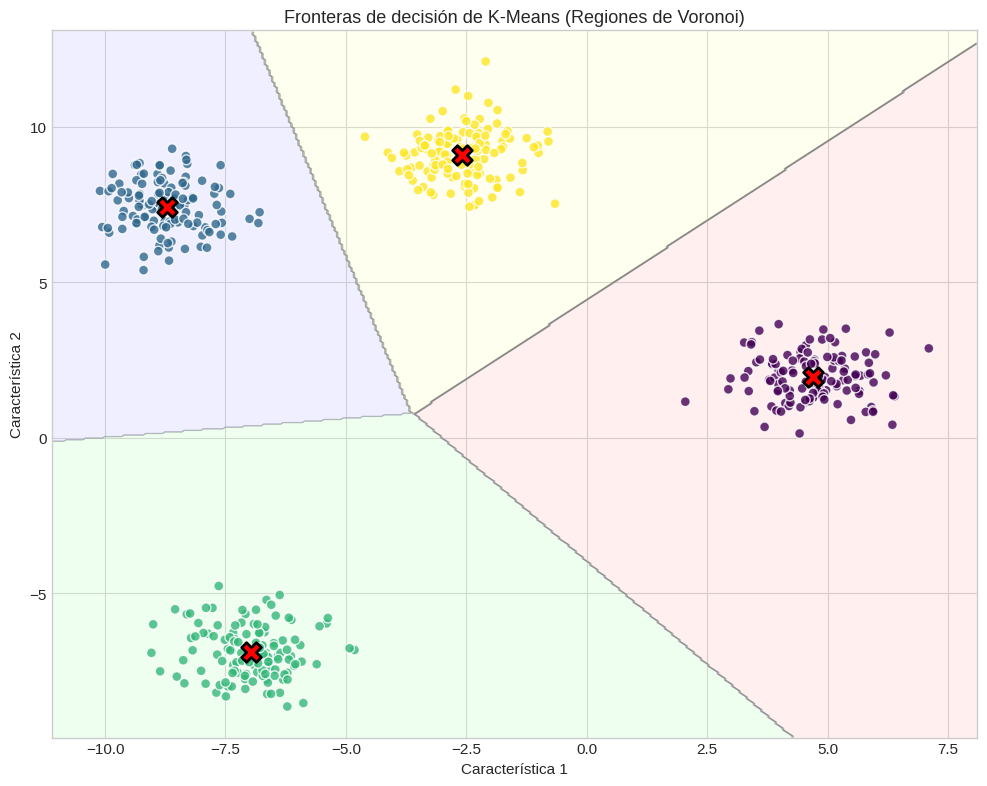

In [ ]:
def visualizar_fronteras_decision(X, modelo, ax, titulo):
    """
    Visualiza las fronteras de decisión de un modelo de clustering.
    """
    # Crear malla para visualización
    h = 0.05
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predecir clusters para cada punto de la malla
    Z = modelo.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Visualizar regiones
    cmap_light = ListedColormap(['#ffcccc', '#ccccff', '#ccffcc', '#ffffcc'])
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    ax.contour(xx, yy, Z, colors='gray', linewidths=0.5, alpha=0.5)

    # Puntos y centroides
    scatter = ax.scatter(X[:, 0], X[:, 1], c=modelo.labels_, cmap='viridis',
                        edgecolors='w', s=50, alpha=0.8)
    ax.scatter(modelo.cluster_centers_[:, 0], modelo.cluster_centers_[:, 1],
              c='red', marker='X', s=200, edgecolors='black', linewidths=2)

    ax.set_xlabel('Característica 1')
    ax.set_ylabel('Característica 2')
    ax.set_title(titulo)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Visualización
fig, ax = plt.subplots(figsize=(10, 8))
visualizar_fronteras_decision(X, kmeans_sklearn, ax, 'Fronteras de decisión de K-Means (Regiones de Voronoi)')
plt.tight_layout()
plt.show()

## 5. Selección del Número Óptimo de Clusters

Uno de los principales desafíos de K-Means es determinar el valor apropiado de k. Analizamos tres métodos ampliamente utilizados.

### 5.1 Método del Codo (Elbow Method)

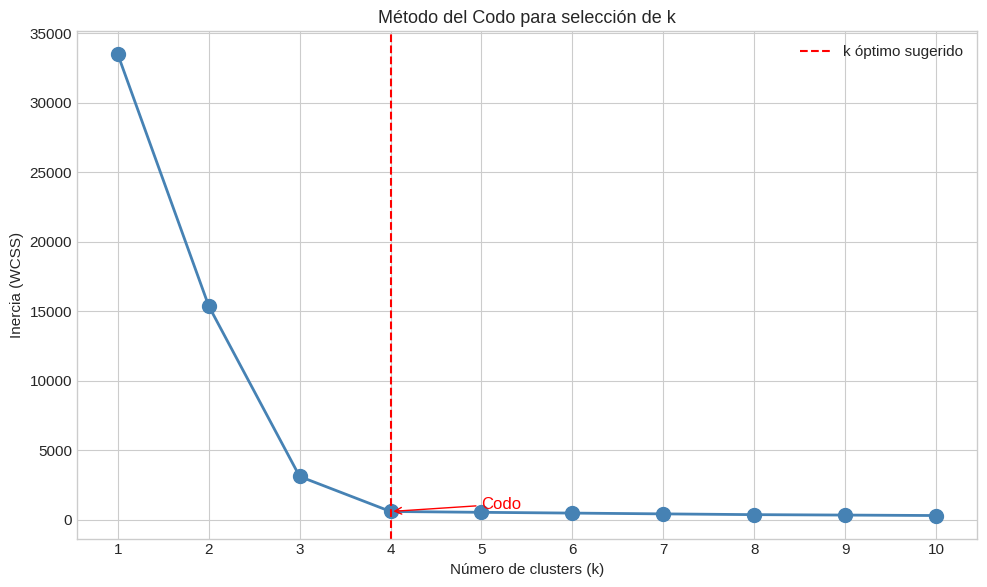

In [ ]:
# Calcular inercia para diferentes valores de k
k_range = range(1, 11)
inercias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=RANDOM_STATE)
    kmeans.fit(X)
    inercias.append(kmeans.inertia_)

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(k_range, inercias, 'o-', color='steelblue', linewidth=2, markersize=10)
ax.axvline(x=4, color='red', linestyle='--', linewidth=1.5, label='k óptimo sugerido')

ax.set_xlabel('Número de clusters (k)')
ax.set_ylabel('Inercia (WCSS)')
ax.set_title('Método del Codo para selección de k')
ax.set_xticks(k_range)
ax.legend()

# Anotar el punto del codo
ax.annotate('Codo', xy=(4, inercias[3]), xytext=(5, inercias[3] + 200),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=12, color='red')

plt.tight_layout()
plt.show()

### 5.2 Método de la Silueta (Silhouette Method)

El coeficiente de silueta mide la cohesión intra-cluster y la separación inter-cluster.

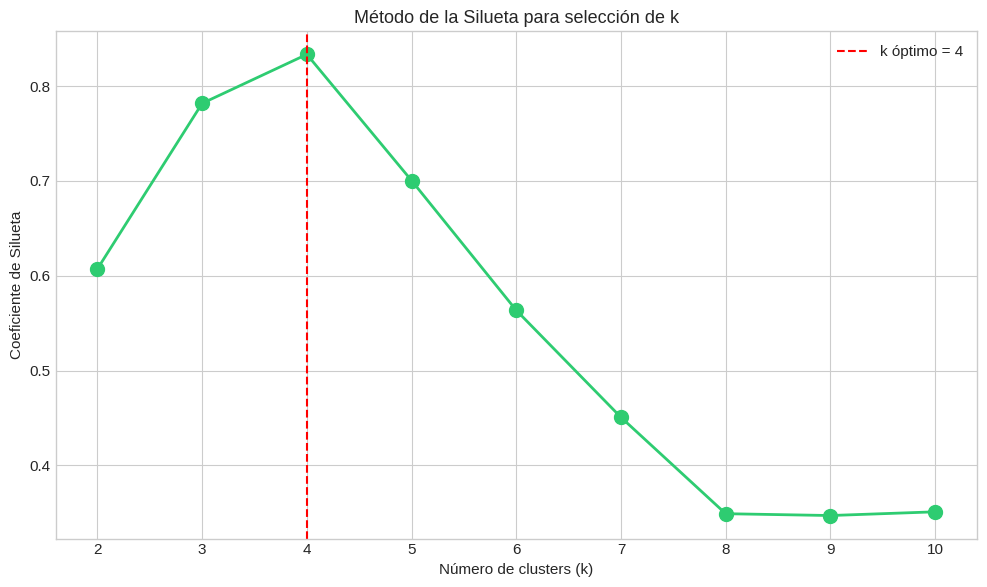


Coeficientes de silueta por k:
  k=2: 0.6072
  k=3: 0.7819
  k=4: 0.8336
  k=5: 0.7005
  k=6: 0.5635
  k=7: 0.4506
  k=8: 0.3489
  k=9: 0.3470
  k=10: 0.3509


In [ ]:
# Calcular coeficiente de silueta para diferentes valores de k
k_range_silhouette = range(2, 11)  # Silueta requiere k >= 2
siluetas = []

for k in k_range_silhouette:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X)
    siluetas.append(silhouette_score(X, labels))

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(k_range_silhouette, siluetas, 'o-', color='#2ecc71', linewidth=2, markersize=10)
ax.axvline(x=k_range_silhouette[np.argmax(siluetas)], color='red', linestyle='--',
           linewidth=1.5, label=f'k óptimo = {k_range_silhouette[np.argmax(siluetas)]}')

ax.set_xlabel('Número de clusters (k)')
ax.set_ylabel('Coeficiente de Silueta')
ax.set_title('Método de la Silueta para selección de k')
ax.set_xticks(k_range_silhouette)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nCoeficientes de silueta por k:")
for k, s in zip(k_range_silhouette, siluetas):
    print(f"  k={k}: {s:.4f}")

### 5.3 Diagrama de Siluetas por Cluster

Visualización detallada que permite evaluar la calidad de cada cluster individualmente.

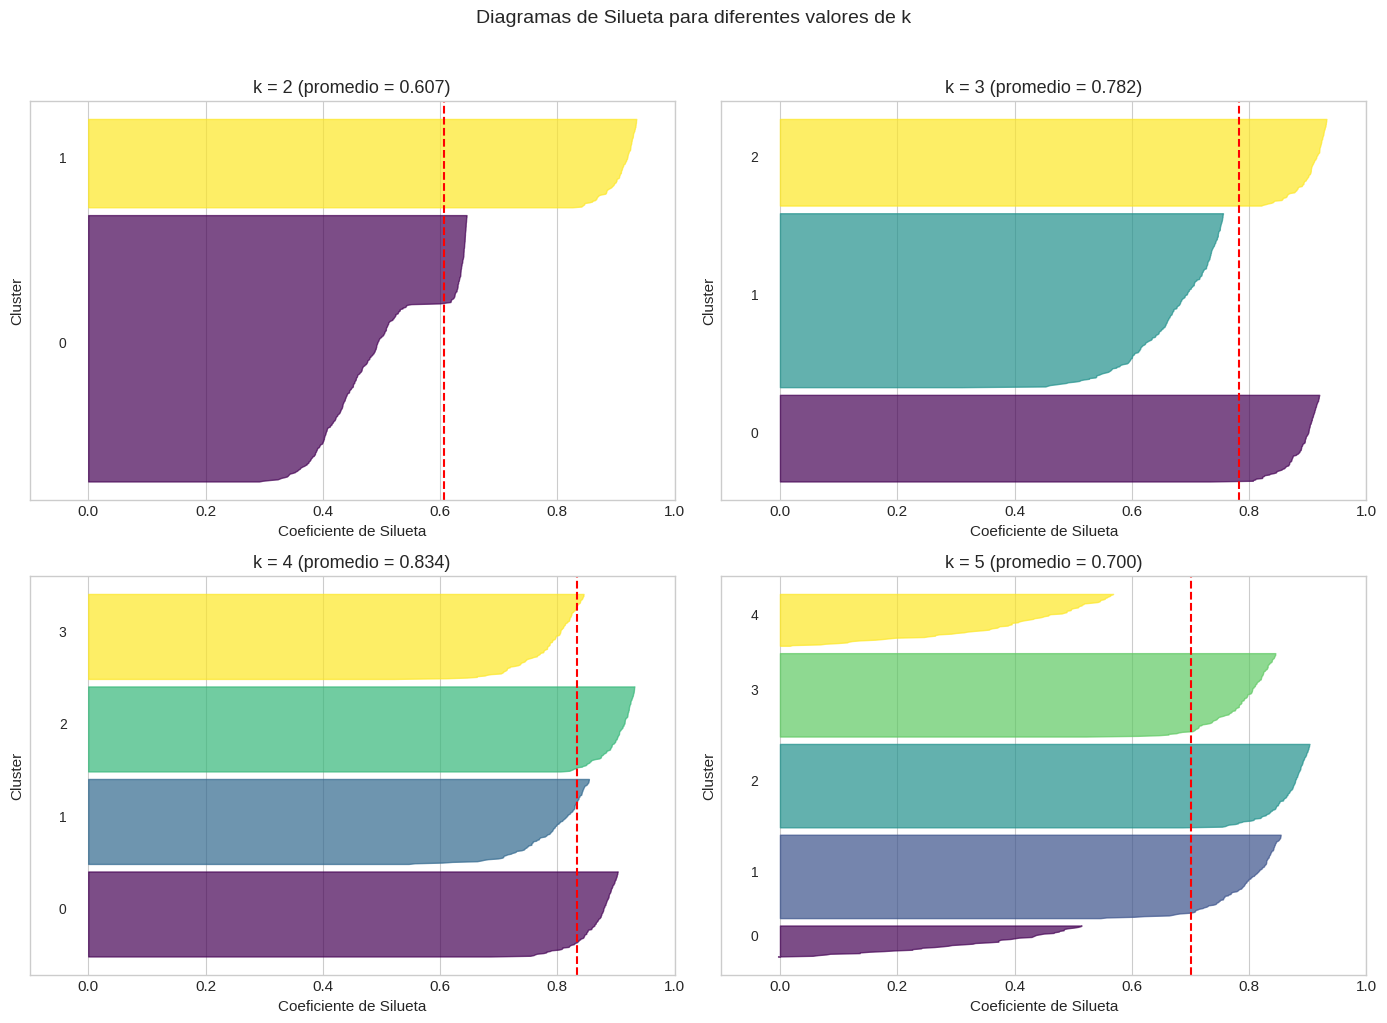

In [ ]:
def graficar_siluetas(X, n_clusters, ax):
    """
    Genera un diagrama de siluetas para un número específico de clusters.
    """
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X)

    # Calcular siluetas individuales
    siluetas_muestras = silhouette_samples(X, labels)
    silueta_promedio = silhouette_score(X, labels)

    y_lower = 10
    colores = plt.cm.viridis(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        siluetas_cluster = siluetas_muestras[labels == i]
        siluetas_cluster.sort()

        tamaño_cluster = len(siluetas_cluster)
        y_upper = y_lower + tamaño_cluster

        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, siluetas_cluster,
                        alpha=0.7, color=colores[i])
        ax.text(-0.05, y_lower + 0.5 * tamaño_cluster, str(i), fontsize=10)

        y_lower = y_upper + 10

    ax.axvline(x=silueta_promedio, color='red', linestyle='--', linewidth=1.5)
    ax.set_xlabel('Coeficiente de Silueta')
    ax.set_ylabel('Cluster')
    ax.set_title(f'k = {n_clusters} (promedio = {silueta_promedio:.3f})')
    ax.set_xlim([-0.1, 1])
    ax.set_yticks([])

# Comparación de diferentes valores de k
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, k in enumerate([2, 3, 4, 5]):
    ax = axes[idx // 2, idx % 2]
    graficar_siluetas(X, k, ax)

plt.suptitle('Diagramas de Silueta para diferentes valores de k', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Mini-Batch K-Means

Variante escalable de K-Means que utiliza mini-batches para actualizar los centroides, reduciendo significativamente el tiempo de cómputo.

In [ ]:
# Generar un dataset más grande para comparación
X_grande, _ = make_blobs(n_samples=10000, n_features=2, centers=5,
                         cluster_std=1.0, random_state=RANDOM_STATE)

import time

# K-Means estándar
inicio = time.time()
kmeans_std = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=RANDOM_STATE)
kmeans_std.fit(X_grande)
tiempo_std = time.time() - inicio

# Mini-Batch K-Means
inicio = time.time()
kmeans_mb = MiniBatchKMeans(n_clusters=5, init='k-means++', n_init=10,
                            batch_size=256, random_state=RANDOM_STATE)
kmeans_mb.fit(X_grande)
tiempo_mb = time.time() - inicio

# Resultados
print("Comparación K-Means vs Mini-Batch K-Means (n=10,000)")
print("=" * 55)
print(f"{'Métrica':<25} {'K-Means':<15} {'Mini-Batch':<15}")
print("-" * 55)
print(f"{'Tiempo (segundos)':<25} {tiempo_std:<15.4f} {tiempo_mb:<15.4f}")
print(f"{'Inercia':<25} {kmeans_std.inertia_:<15.2f} {kmeans_mb.inertia_:<15.2f}")
print(f"{'Speedup':<25} {'-':<15} {tiempo_std/tiempo_mb:<15.2f}x")

Comparación K-Means vs Mini-Batch K-Means (n=10,000)
Métrica                   K-Means         Mini-Batch     
-------------------------------------------------------
Tiempo (segundos)         0.0442          0.0260         
Inercia                   19490.06        19496.69       
Speedup                   -               1.70           x


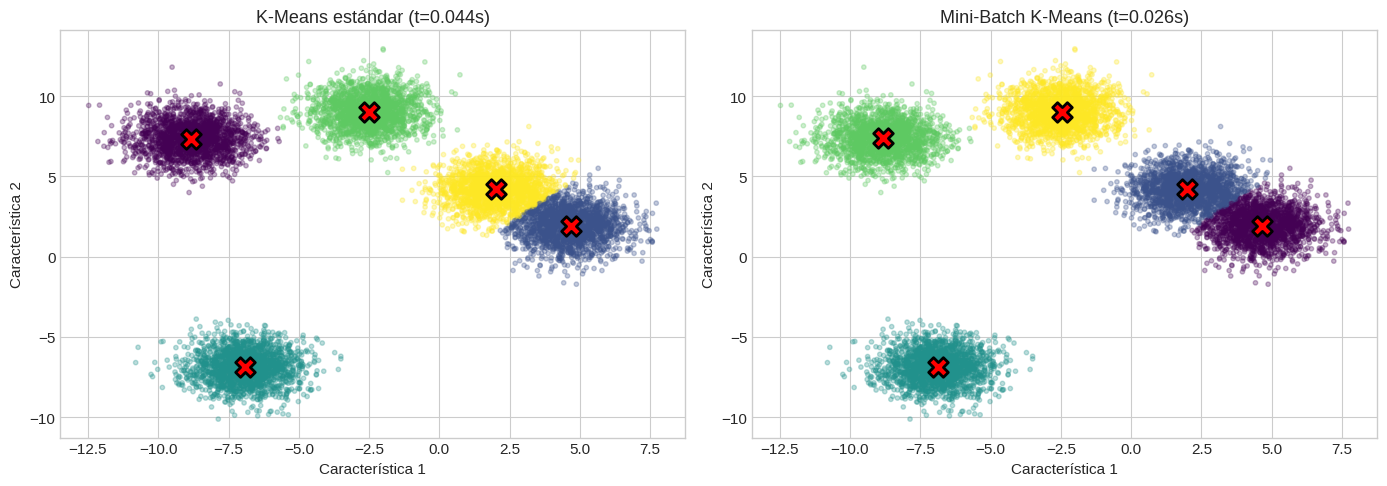

In [ ]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# K-Means estándar
axes[0].scatter(X_grande[:, 0], X_grande[:, 1], c=kmeans_std.labels_,
                cmap='viridis', alpha=0.3, s=10)
axes[0].scatter(kmeans_std.cluster_centers_[:, 0], kmeans_std.cluster_centers_[:, 1],
                c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[0].set_title(f'K-Means estándar (t={tiempo_std:.3f}s)')
axes[0].set_xlabel('Característica 1')
axes[0].set_ylabel('Característica 2')

# Mini-Batch K-Means
axes[1].scatter(X_grande[:, 0], X_grande[:, 1], c=kmeans_mb.labels_,
                cmap='viridis', alpha=0.3, s=10)
axes[1].scatter(kmeans_mb.cluster_centers_[:, 0], kmeans_mb.cluster_centers_[:, 1],
                c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[1].set_title(f'Mini-Batch K-Means (t={tiempo_mb:.3f}s)')
axes[1].set_xlabel('Característica 1')
axes[1].set_ylabel('Característica 2')

plt.tight_layout()
plt.show()

## 7. Limitaciones de K-Means

Ilustramos las principales limitaciones del algoritmo mediante ejemplos visuales.

### 7.1 Clusters de Forma No Esférica

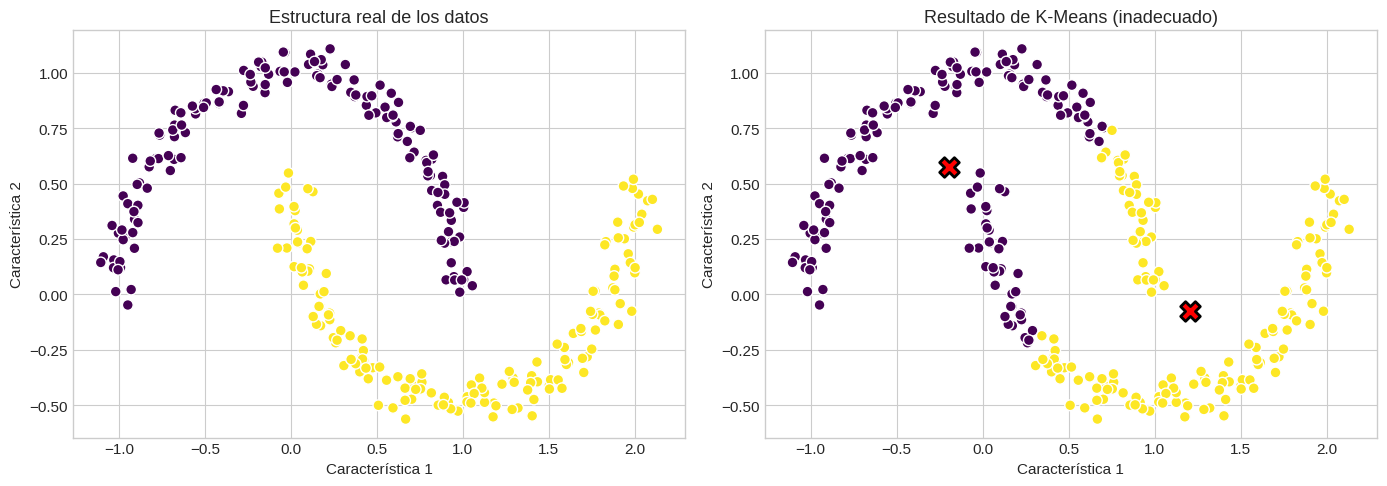

K-Means asume clusters esféricos y no puede capturar estructuras con formas arbitrarias.
Para este tipo de datos, se recomienda usar DBSCAN o clustering espectral.


In [ ]:
# Datos con forma de lunas (no esféricos)
X_moons, y_moons = make_moons(n_samples=300, noise=0.05, random_state=RANDOM_STATE)

# Aplicar K-Means
kmeans_moons = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=RANDOM_STATE)
labels_kmeans = kmeans_moons.fit_predict(X_moons)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ground truth
axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis',
                edgecolors='w', s=60)
axes[0].set_title('Estructura real de los datos')
axes[0].set_xlabel('Característica 1')
axes[0].set_ylabel('Característica 2')

# K-Means
axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=labels_kmeans, cmap='viridis',
                edgecolors='w', s=60)
axes[1].scatter(kmeans_moons.cluster_centers_[:, 0], kmeans_moons.cluster_centers_[:, 1],
                c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[1].set_title('Resultado de K-Means (inadecuado)')
axes[1].set_xlabel('Característica 1')
axes[1].set_ylabel('Característica 2')

plt.tight_layout()
plt.show()

print("K-Means asume clusters esféricos y no puede capturar estructuras con formas arbitrarias.")
print("Para este tipo de datos, se recomienda usar DBSCAN o clustering espectral.")

### 7.2 Sensibilidad a Outliers

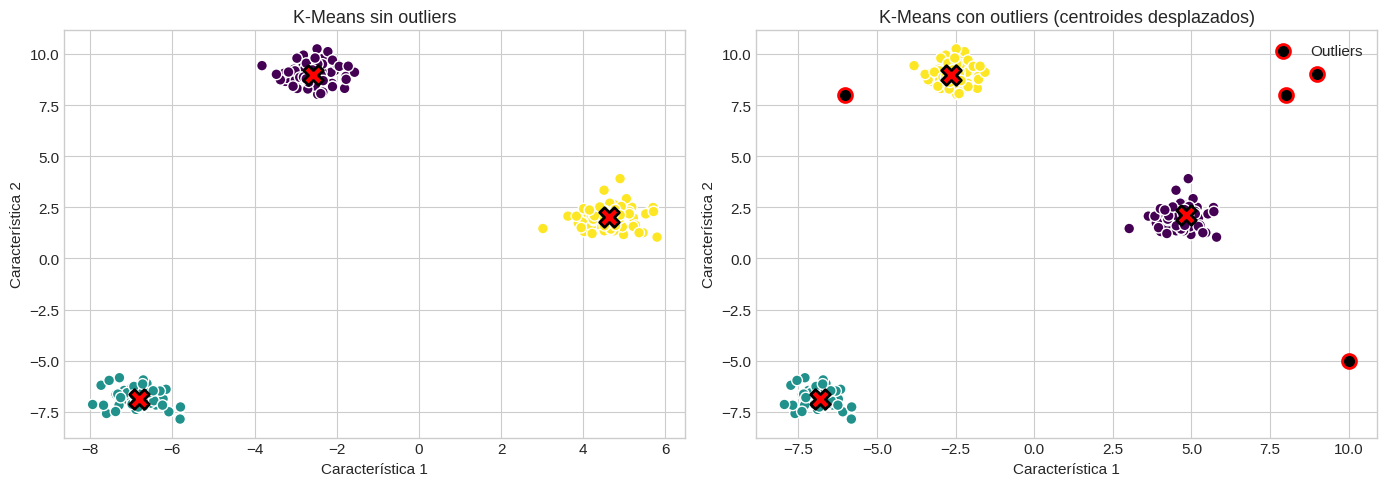

Los outliers pueden desplazar significativamente los centroides.
Se recomienda usar K-Medoids (PAM) o preprocesar los datos eliminando outliers.


In [ ]:
# Datos con outliers
X_base, _ = make_blobs(n_samples=200, n_features=2, centers=3,
                       cluster_std=0.5, random_state=RANDOM_STATE)

# Añadir outliers
outliers = np.array([[8, 8], [9, 9], [-6, 8], [10, -5]])
X_outliers = np.vstack([X_base, outliers])

# K-Means sin outliers
kmeans_sin = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=RANDOM_STATE)
kmeans_sin.fit(X_base)

# K-Means con outliers
kmeans_con = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=RANDOM_STATE)
kmeans_con.fit(X_outliers)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sin outliers
axes[0].scatter(X_base[:, 0], X_base[:, 1], c=kmeans_sin.labels_,
                cmap='viridis', edgecolors='w', s=60)
axes[0].scatter(kmeans_sin.cluster_centers_[:, 0], kmeans_sin.cluster_centers_[:, 1],
                c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[0].set_title('K-Means sin outliers')
axes[0].set_xlabel('Característica 1')
axes[0].set_ylabel('Característica 2')

# Con outliers
axes[1].scatter(X_outliers[:, 0], X_outliers[:, 1], c=kmeans_con.labels_,
                cmap='viridis', edgecolors='w', s=60)
axes[1].scatter(kmeans_con.cluster_centers_[:, 0], kmeans_con.cluster_centers_[:, 1],
                c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[1].scatter(outliers[:, 0], outliers[:, 1], c='black', marker='o', s=100,
                edgecolors='red', linewidths=2, label='Outliers')
axes[1].set_title('K-Means con outliers (centroides desplazados)')
axes[1].set_xlabel('Característica 1')
axes[1].set_ylabel('Característica 2')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Los outliers pueden desplazar significativamente los centroides.")
print("Se recomienda usar K-Medoids (PAM) o preprocesar los datos eliminando outliers.")

## 8. Ejercicio Práctico: Segmentación de Clientes

Aplicamos K-Means a un problema real de segmentación de clientes utilizando el análisis RFM (Recency, Frequency, Monetary).

### 8.1 Generación de Datos de Clientes

In [ ]:
# Simulación de datos de clientes (RFM)
np.random.seed(RANDOM_STATE)
n_clientes = 500

# Crear segmentos artificiales con diferentes comportamientos
# Segmento 1: Clientes VIP (recientes, frecuentes, alto gasto)
vip = np.column_stack([
    np.random.normal(10, 5, 100),    # Recency (días desde última compra)
    np.random.normal(25, 5, 100),    # Frequency (compras/año)
    np.random.normal(500, 100, 100)  # Monetary (gasto promedio)
])

# Segmento 2: Clientes regulares
regulares = np.column_stack([
    np.random.normal(45, 15, 150),
    np.random.normal(10, 3, 150),
    np.random.normal(150, 50, 150)
])

# Segmento 3: Clientes ocasionales
ocasionales = np.column_stack([
    np.random.normal(90, 20, 150),
    np.random.normal(4, 2, 150),
    np.random.normal(80, 30, 150)
])

# Segmento 4: Clientes dormidos (churned)
dormidos = np.column_stack([
    np.random.normal(200, 50, 100),
    np.random.normal(2, 1, 100),
    np.random.normal(50, 20, 100)
])

# Combinar datos
X_rfm = np.vstack([vip, regulares, ocasionales, dormidos])
X_rfm = np.abs(X_rfm)  # Asegurar valores positivos

# Crear DataFrame
df_clientes = pd.DataFrame(X_rfm, columns=['Recency', 'Frequency', 'Monetary'])
df_clientes['CustomerID'] = range(1, len(df_clientes) + 1)

print("Dataset de clientes (primeras filas):")
print(df_clientes.head(10))
print(f"\nDimensiones: {df_clientes.shape}")
print(f"\nEstadísticas descriptivas:")
print(df_clientes[['Recency', 'Frequency', 'Monetary']].describe())

Dataset de clientes (primeras filas):
     Recency  Frequency    Monetary  CustomerID
0  12.483571  17.923146  535.778736           1
1   9.308678  22.896773  556.078453           2
2  13.238443  23.286427  608.305124           3
3  17.615149  20.988614  605.380205           4
4   8.829233  24.193571  362.233063           5
5   8.829315  27.020254  406.217496           6
6  17.896064  34.430930  551.503527           7
7  13.837174  25.872889  551.378595           8
8   7.652628  26.287752  551.504769           9
9  12.712800  24.627770  885.273149          10

Dimensiones: (500, 4)

Estadísticas descriptivas:
          Recency   Frequency    Monetary
count  500.000000  500.000000  500.000000
mean    84.310992    9.613628  181.496691
std     71.072817    8.755338  176.492706
min      0.062155    0.024533    5.017829
25%     32.524849    3.033277   67.196239
50%     67.768322    6.757769  107.886317
75%    111.315579   12.356501  199.530538
max    328.985467   38.600846  885.273149


### 8.2 Preprocesamiento: Estandarización

In [ ]:
# Seleccionar características RFM
features = ['Recency', 'Frequency', 'Monetary']
X_rfm_raw = df_clientes[features].values

# Estandarización
scaler = StandardScaler()
X_rfm_scaled = scaler.fit_transform(X_rfm_raw)

print("Datos estandarizados (media=0, std=1):")
print(f"Media por característica: {X_rfm_scaled.mean(axis=0).round(4)}")
print(f"Desviación estándar: {X_rfm_scaled.std(axis=0).round(4)}")

Datos estandarizados (media=0, std=1):
Media por característica: [ 0. -0. -0.]
Desviación estándar: [1. 1. 1.]


### 8.3 Determinación del Número de Segmentos

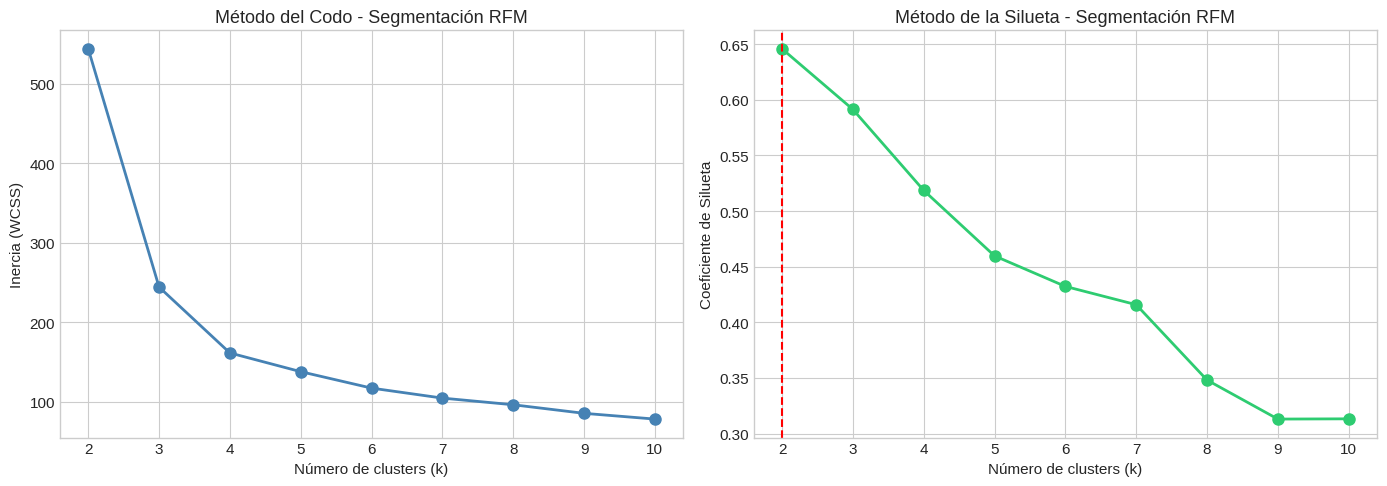


Número óptimo de segmentos según silueta: k = 2


In [ ]:
# Análisis del número óptimo de clusters
k_range = range(2, 11)
inercias_rfm = []
siluetas_rfm = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X_rfm_scaled)
    inercias_rfm.append(kmeans.inertia_)
    siluetas_rfm.append(silhouette_score(X_rfm_scaled, labels))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Método del codo
axes[0].plot(k_range, inercias_rfm, 'o-', color='steelblue', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de clusters (k)')
axes[0].set_ylabel('Inercia (WCSS)')
axes[0].set_title('Método del Codo - Segmentación RFM')
axes[0].set_xticks(k_range)

# Silueta
axes[1].plot(k_range, siluetas_rfm, 'o-', color='#2ecc71', linewidth=2, markersize=8)
axes[1].axvline(x=k_range[np.argmax(siluetas_rfm)], color='red', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('Número de clusters (k)')
axes[1].set_ylabel('Coeficiente de Silueta')
axes[1].set_title('Método de la Silueta - Segmentación RFM')
axes[1].set_xticks(k_range)

plt.tight_layout()
plt.show()

k_optimo = k_range[np.argmax(siluetas_rfm)]
print(f"\nNúmero óptimo de segmentos según silueta: k = {k_optimo}")

### 8.4 Segmentación Final y Perfilado

In [ ]:
# Ajustar modelo con k óptimo
kmeans_final = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=RANDOM_STATE)
df_clientes['Segmento'] = kmeans_final.fit_predict(X_rfm_scaled)

# Perfilado de segmentos
perfil_segmentos = df_clientes.groupby('Segmento')[features].agg(['mean', 'std', 'count'])

print("Perfil de segmentos (valores originales):")
print("=" * 80)

for segmento in sorted(df_clientes['Segmento'].unique()):
    datos_seg = df_clientes[df_clientes['Segmento'] == segmento][features]
    print(f"\nSegmento {segmento} (n = {len(datos_seg)} clientes):")
    print(f"  Recency:   {datos_seg['Recency'].mean():.1f} ± {datos_seg['Recency'].std():.1f} días")
    print(f"  Frequency: {datos_seg['Frequency'].mean():.1f} ± {datos_seg['Frequency'].std():.1f} compras/año")
    print(f"  Monetary:  ${datos_seg['Monetary'].mean():.1f} ± ${datos_seg['Monetary'].std():.1f}")

Perfil de segmentos (valores originales):

Segmento 0 (n = 167 clientes):
  Recency:   96.9 ± 21.4 días
  Frequency: 4.0 ± 1.9 compras/año
  Monetary:  $80.4 ± $33.2

Segmento 1 (n = 100 clientes):
  Recency:   9.5 ± 4.4 días
  Frequency: 25.1 ± 4.8 compras/año
  Monetary:  $506.5 ± $108.4

Segmento 2 (n = 148 clientes):
  Recency:   45.5 ± 14.0 días
  Frequency: 9.8 ± 2.8 compras/año
  Monetary:  $147.7 ± $52.2

Segmento 3 (n = 85 clientes):
  Recency:   215.1 ± 42.3 días
  Frequency: 2.0 ± 0.9 compras/año
  Monetary:  $56.5 ± $19.8


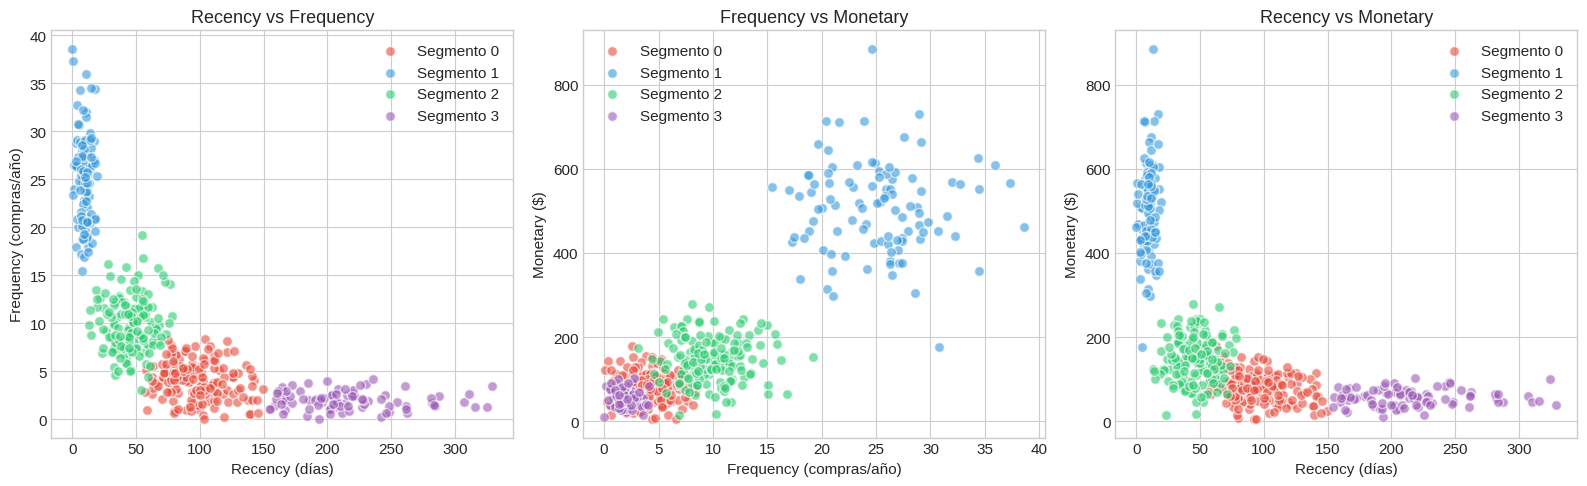

In [ ]:
# Visualización de segmentos
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colores_segmentos = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
nombres_segmentos = ['Segmento 0', 'Segmento 1', 'Segmento 2', 'Segmento 3']

# Recency vs Frequency
for seg in range(4):
    mask = df_clientes['Segmento'] == seg
    axes[0].scatter(df_clientes.loc[mask, 'Recency'],
                    df_clientes.loc[mask, 'Frequency'],
                    c=colores_segmentos[seg], label=nombres_segmentos[seg],
                    alpha=0.6, edgecolors='w', s=50)
axes[0].set_xlabel('Recency (días)')
axes[0].set_ylabel('Frequency (compras/año)')
axes[0].set_title('Recency vs Frequency')
axes[0].legend()

# Frequency vs Monetary
for seg in range(4):
    mask = df_clientes['Segmento'] == seg
    axes[1].scatter(df_clientes.loc[mask, 'Frequency'],
                    df_clientes.loc[mask, 'Monetary'],
                    c=colores_segmentos[seg], label=nombres_segmentos[seg],
                    alpha=0.6, edgecolors='w', s=50)
axes[1].set_xlabel('Frequency (compras/año)')
axes[1].set_ylabel('Monetary ($)')
axes[1].set_title('Frequency vs Monetary')
axes[1].legend()

# Recency vs Monetary
for seg in range(4):
    mask = df_clientes['Segmento'] == seg
    axes[2].scatter(df_clientes.loc[mask, 'Recency'],
                    df_clientes.loc[mask, 'Monetary'],
                    c=colores_segmentos[seg], label=nombres_segmentos[seg],
                    alpha=0.6, edgecolors='w', s=50)
axes[2].set_xlabel('Recency (días)')
axes[2].set_ylabel('Monetary ($)')
axes[2].set_title('Recency vs Monetary')
axes[2].legend()

plt.tight_layout()
plt.show()

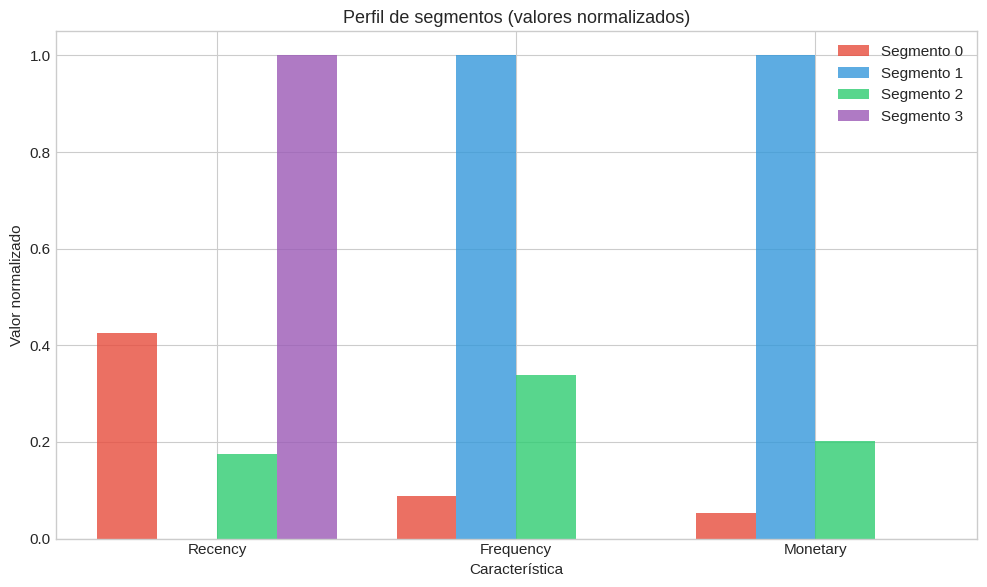

In [ ]:
# Visualización de centroides normalizados (radar chart simplificado)
centroides_originales = scaler.inverse_transform(kmeans_final.cluster_centers_)

# Normalizar para comparación visual
centroides_norm = (centroides_originales - centroides_originales.min(axis=0)) / \
                  (centroides_originales.max(axis=0) - centroides_originales.min(axis=0))

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(features))
width = 0.2

for i in range(4):
    ax.bar(x + i * width, centroides_norm[i], width, label=f'Segmento {i}',
           color=colores_segmentos[i], alpha=0.8)

ax.set_xlabel('Característica')
ax.set_ylabel('Valor normalizado')
ax.set_title('Perfil de segmentos (valores normalizados)')
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(features)
ax.legend()

plt.tight_layout()
plt.show()

### 8.5 Interpretación de Segmentos

In [ ]:
# Asignar nombres descriptivos a los segmentos basándose en su perfil
def interpretar_segmento(row):
    """
    Asigna una etiqueta descriptiva basada en el perfil RFM.
    """
    if row['Recency'] < 30 and row['Frequency'] > 15 and row['Monetary'] > 300:
        return 'VIP'
    elif row['Recency'] < 60 and row['Frequency'] > 7:
        return 'Regular'
    elif row['Recency'] < 120:
        return 'Ocasional'
    else:
        return 'En riesgo'

# Aplicar interpretación
centroides_df = pd.DataFrame(centroides_originales, columns=features)
centroides_df['Interpretacion'] = centroides_df.apply(interpretar_segmento, axis=1)

print("\nInterpretación de segmentos:")
print("=" * 70)
for idx, row in centroides_df.iterrows():
    print(f"\nSegmento {idx} - {row['Interpretacion']}:")
    print(f"  Recency:   {row['Recency']:.1f} días")
    print(f"  Frequency: {row['Frequency']:.1f} compras/año")
    print(f"  Monetary:  ${row['Monetary']:.1f}")

print("\n" + "=" * 70)
print("\nRecomendaciones de negocio:")
print("- VIP: Programas de fidelización y beneficios exclusivos")
print("- Regular: Incentivos para aumentar frecuencia de compra")
print("- Ocasional: Campañas de reactivación y ofertas personalizadas")
print("- En riesgo: Estrategias de win-back urgentes")


Interpretación de segmentos:

Segmento 0 - Ocasional:
  Recency:   96.9 días
  Frequency: 4.0 compras/año
  Monetary:  $80.4

Segmento 1 - VIP:
  Recency:   9.5 días
  Frequency: 25.1 compras/año
  Monetary:  $506.5

Segmento 2 - Regular:
  Recency:   45.5 días
  Frequency: 9.8 compras/año
  Monetary:  $147.7

Segmento 3 - En riesgo:
  Recency:   215.1 días
  Frequency: 2.0 compras/año
  Monetary:  $56.5


Recomendaciones de negocio:
- VIP: Programas de fidelización y beneficios exclusivos
- Regular: Incentivos para aumentar frecuencia de compra
- Ocasional: Campañas de reactivación y ofertas personalizadas
- En riesgo: Estrategias de win-back urgentes


## 9. Resumen y Conclusiones

### Conceptos Clave

1. **K-Means** es un algoritmo de particionamiento que minimiza la inercia (WCSS) mediante iteración entre asignación de puntos y actualización de centroides.

2. **K-Means++** mejora significativamente la inicialización, reduciendo la variabilidad en los resultados y acelerando la convergencia.

3. **Mini-Batch K-Means** ofrece una alternativa escalable para datasets grandes, con un trade-off aceptable en calidad.

4. La **selección del número de clusters** puede realizarse mediante el método del codo, coeficiente de silueta o gap statistic.

5. K-Means tiene **limitaciones** importantes: asume clusters esféricos, de tamaño similar, y es sensible a outliers.

### Criterios de Selección

| Situación | Recomendación |
|-----------|---------------|
| Dataset grande | Mini-Batch K-Means |
| Presencia de outliers | K-Medoids |
| Clusters no esféricos | DBSCAN, GMM |
| Datos categóricos | K-Modes |
| Datos mixtos | K-Prototypes |

---

## Referencias

- Lloyd, S. (1982). Least squares quantization in PCM. *IEEE Transactions on Information Theory*, 28(2), 129-137.
- Arthur, D., & Vassilvitskii, S. (2007). k-means++: The advantages of careful seeding. *SODA '07*.
- Sculley, D. (2010). Web-scale k-means clustering. *WWW '10*.
- Scikit-learn documentation: https://scikit-learn.org/stable/modules/clustering.html

---


# EOF (End Of File)